# Implementing a CNN for MNIST dataset

**Importing modules**

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(f"Torch version:       {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Torch version:       2.3.1+cu121
Torchvision version: 0.18.1+cu121


**Device Agnostic Code**

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current Device: {device}")

Current Device: cuda


## Retrieving the dataset

Using MNIST dataset from Torchvision

In [3]:
# TRAINING DATA
train_data = datasets.MNIST(
    root="data", # Download directory
    train=True,  # Training dataset
    download=True,
    transform=torchvision.transforms.ToTensor(),    # Transformation of data
    target_transform=None     # Transformation of labels
)

# TESTING DATA
test_data = datasets.MNIST(
    root="data", # Download directory
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15860316.87it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 510631.98it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4263058.38it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8410829.48it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
image, label = train_data[0]
image.size(), label

(torch.Size([1, 28, 28]), 5)

In [6]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [7]:
class_idx = train_data.class_to_idx
class_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

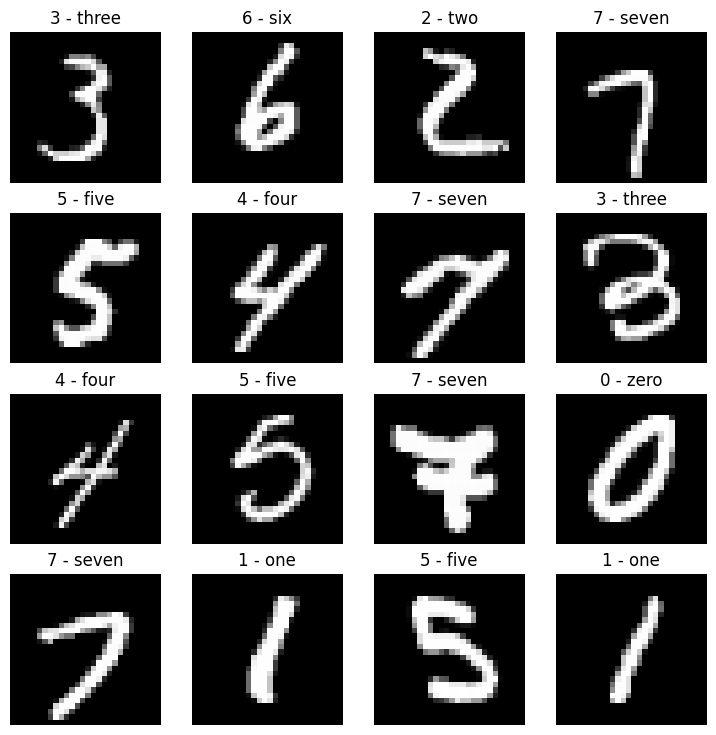

In [8]:
# torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [9]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders: {train_dataloader, test_dataloader}\n")
print(f"Length of train_dataloader: {len(train_dataloader)} with batch size {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} with batch size {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b7e891f6bf0>, <torch.utils.data.dataloader.DataLoader object at 0x7b7e891f61d0>)

Length of train_dataloader: 1875 with batch size 32
Length of test_dataloader: 313 with batch size 32


In [11]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 8, Label size: torch.Size([])


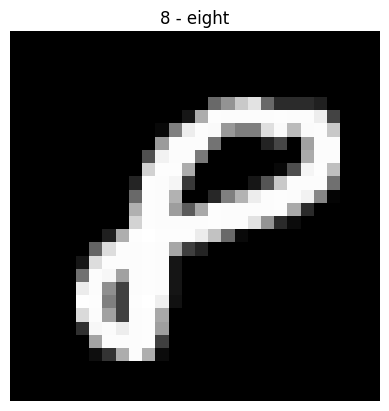

In [12]:
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, Label size: {label.shape}")

In [13]:
class Model_CNN(nn.Module):
  def __init__(self, output_shape: int):
    super().__init__()
    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=20, kernel_size=9, stride=1, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )
    self.fc_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=20*10*10, out_features=100),
        nn.ReLU(),
        nn.Linear(in_features=100, out_features=output_shape),
        nn.Softmax(dim=1)
    )

  def forward(self,x):
    x = self.conv_layer(x)
    x = self.fc_layer(x)
    return x

In [14]:
torch.manual_seed(42)

model = Model_CNN(output_shape=len(class_names)).to(device)

model

Model_CNN(
  (conv_layer): Sequential(
    (0): Conv2d(1, 20, kernel_size=(9, 9), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2000, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [ ]:
# model.state_dict()

In [15]:
import requests
from pathlib import Path

file_name = "helper_functions.py"
if Path(file_name).is_file():
  print(f"Note: {file_name} already exists.")
else:
  print(f"Downloading {file_name}")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open(file_name, "wb") as f:
    f.write(request.content)

In [16]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, momentum=0.9)

In [17]:
# FUNCTION TO CALCULATE TIMING

from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
  """ Prints difference between start and end time."""
  total_time = end - start
  print(f"\nTrain time on {device}: {total_time:.3f} seconds")
  return total_time

In [18]:
# TRAINING FUNCTION
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, device: torch.device=device):
  """Performs a training step with the model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0
  model.train()

  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward propagation
    y_pred = model(X)
    # 2. Calculate Loss and Accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Backpropagation
    loss.backward()
    # 5. Update parameters
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%")

# TESTING FUNCTION
def test_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, accuracy_fn, device: torch.device=device):
  """Performs a testing step with the model going over data_loader."""
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # Put data on target device
      X, y = X.to(device), y.to(device)

      # 1. Forward propagation
      test_pred = model(X)
      # 2. Calculate Loss and Accuracy
      test_loss = loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  """Returns a dictionary containing the results of model predictions on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Put data on target device
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [19]:
# TRAINING

from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start = timer()

EPOCHS = 5

for epoch in tqdm(range(EPOCHS)):
  print(f"\nEpoch: {epoch+1}\n----------")
  train_step(model=model,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end = timer()
total_train_time = print_train_time(start=train_time_start,
                                          end=train_time_end,
                                          device=device)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
----------
Train Loss: 1.58917 | Train Accuracy: 87.35%
Test Loss: 0.00467 | Test Accuracy: 96.72%

Epoch: 1
----------
Train Loss: 1.49666 | Train Accuracy: 96.45%
Test Loss: 0.00467 | Test Accuracy: 97.17%

Epoch: 2
----------
Train Loss: 1.48832 | Train Accuracy: 97.27%
Test Loss: 0.00467 | Test Accuracy: 97.47%

Epoch: 3
----------
Train Loss: 1.48576 | Train Accuracy: 97.53%
Test Loss: 0.00467 | Test Accuracy: 97.06%

Epoch: 4
----------
Train Loss: 1.48827 | Train Accuracy: 97.28%
Test Loss: 0.00467 | Test Accuracy: 97.33%

Train time on cuda: 59.325 seconds


In [20]:
model_results = eval_model(model=model,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)

model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'Model_CNN',
 'model_loss': 1.4878381490707397,
 'model_acc': 97.33426517571885}

# Evaluate predictions

In [21]:
def make_preds(model: torch.nn.Module, data: list, device: torch.device=device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [22]:
import random
# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

In [23]:
pred_probs = make_preds(model=model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([1, 4, 7, 6, 4, 0, 7, 3, 7])

In [24]:
test_labels

[1, 4, 7, 6, 4, 0, 7, 3, 7]

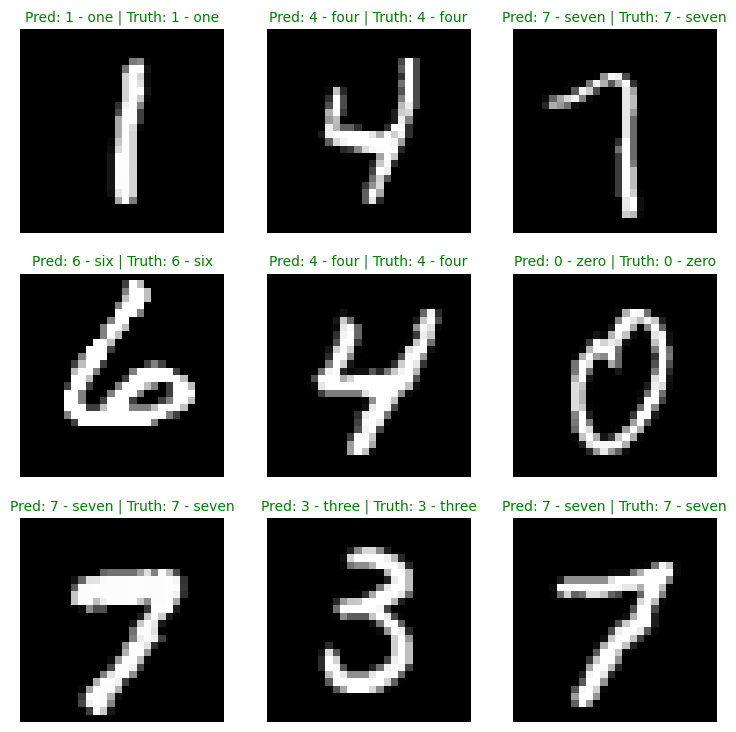

In [25]:
plt.figure(figsize=(9,9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

# Confusion Matrix

In [26]:
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

  y_pred_combined = torch.cat(y_preds)
  print(y_pred_combined)
  print(len(y_pred_combined))

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([7, 2, 1,  ..., 4, 5, 6])
10000


Installing Torchmetrics and MLXtend

In [27]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >=19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 11.1 MB/s eta 0:00:00
mlxtend version: 0.23.1


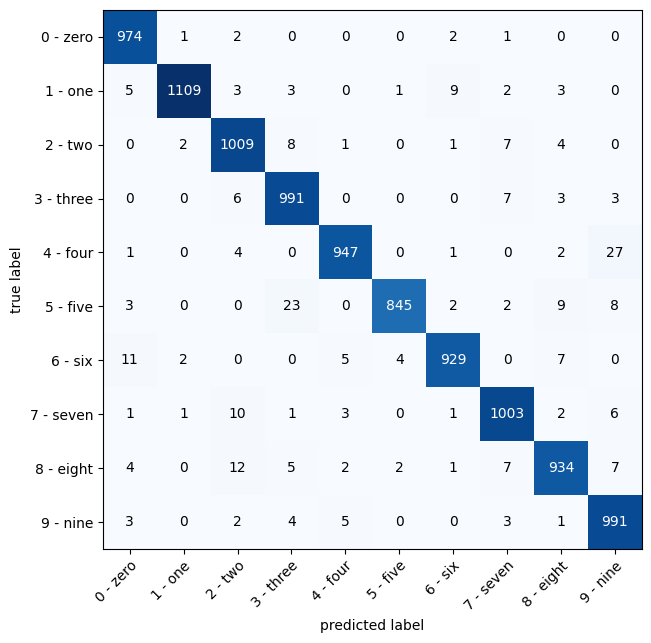

In [28]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task = "multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_combined, target=test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10,7))